# Bitcoin Sentiment Analysis - Google and Reddit EDA

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from data.db_interaction import DatabaseInteraction
from data.time_series_functions import missing_dates_by_year, vs_previous_high

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

### Import Google Trends and Reddit Data

In [2]:
DI = DatabaseInteraction()

gtrends_df = DI.query_to_df(DI.query_all_data('gtrends'))
comments_df = DI.query_to_df(DI.query_all_data('comments'))
posts_df = DI.query_to_df(DI.query_all_data('posts'))

In [3]:
gtrends_df.head()

,date,unscaled_interest,monthly_interest,scale,scaled_interest
0,2015-01-01,38,3.0,0.03,1.14
1,2015-01-02,48,3.0,0.03,1.44
2,2015-01-03,46,3.0,0.03,1.38
3,2015-01-04,64,3.0,0.03,1.92
4,2015-01-05,61,3.0,0.03,1.83


In [4]:
comments_df.head()

,date,timestamp,author,body,upvotes,stickied
0,2018-01-17,1.516188e+09,BashCo,Reminder: [Don't invest recklessly](https://ww...,1,True
1,2018-01-17,1.516200e+09,pabloesco10,*wake up from 3 month coma*\n\nOh wow it's abo...,220,False
2,2018-01-17,1.516201e+09,SmokingHorsey,Why don't we just be honest with ourselves. No...,157,False
3,2018-01-17,1.516201e+09,flavianpatrao,Comments section summed up:\n\n1. The bubble h...,95,False
4,2018-01-17,1.516191e+09,trampabroad,wellthat was a nice holiday from being broke.....,67,False


In [5]:
# Drop duplicate dates from the posts data
posts_df.drop_duplicates(inplace=True)
posts_df.sort_values('date').head()

,date,title,num_comments,url
0,2018-01-02,"Daily Discussion, January 02, 2018",168.0,https://www.reddit.com/r/Bitcoin/comments/7nlj...
1,2018-01-03,"Daily Discussion, January 03, 2018",171.0,https://www.reddit.com/r/Bitcoin/comments/7ntq...
2,2018-01-04,"Daily Discussion, January 04, 2018",358.0,https://www.reddit.com/r/Bitcoin/comments/7o21...
3,2018-01-05,"Daily Discussion, January 05, 2018",553.0,https://www.reddit.com/r/Bitcoin/comments/7oaa...
4,2018-01-06,"Daily Discussion, January 06, 2018",177.0,https://www.reddit.com/r/Bitcoin/comments/7oig...


### Add All-Time High Columns

In [6]:
# Convert gtrends timestamp to date, search for missing dates
gtrends_df['date'] = gtrends_df['date'].dt.date

In [7]:
# Add all time high columns
gtrends_df = vs_previous_high(gtrends_df, 'date', 'scaled_interest')
gtrends_df = vs_previous_high(gtrends_df, 'date', 'scaled_interest', window=365)
posts_df = vs_previous_high(posts_df, 'date', 'num_comments')
posts_df = vs_previous_high(posts_df, 'date', 'num_comments', window=365)

In [8]:
# Add comparison to median columns
gtrends_df = vs_previous_high(gtrends_df, 'date', 'scaled_interest', window=365, function='median')
gtrends_df = vs_previous_high(gtrends_df, 'date', 'scaled_interest', function='median')
posts_df = vs_previous_high(posts_df, 'date', 'num_comments', function='median')

### Activity by Date - Google Trends

The main takeaway from the graphs below is that Google Interest is seriously skewed by a couple of huge days at the end of 2017. This skews the percentage of all-time high metric for all dates following 2017. To combat this, I will need to adjust the calculation for the percentage of all-time high feature. The goal is to have a somewhat normal distribution that will allow for better bucketing. Even adjusting to percentage of the one year high is not sufficient, as the 2018 data is still very skewed and unusable. I imagine that this would also have been a problem for the Reddit data, but the Daily Discussion threads were not started until after 2017, which now makes a lot of sense given the huge rise in Bitcoin interest.

Ultimately, I achieved a more normal distribution by comparing the current daily interest to the prior year **median** rather than the prior year **maximum**. I may also engineer moving average features to further smooth out the noise. The end of 2017 was a crazy time in the life of Bitcoin.

In [9]:
def line_plot_by_date(df, date_column, line_columns, title, xlim=None, ylim=None):
    """
    Plot line graph with date x-axis for a given dataframe.
    """
    fig = plt.figure(figsize=(20,7))
    plt.suptitle(title, fontweight='bold', fontsize=22)
    plt.grid(True)
    for col in line_columns:
        plt.plot(df[date_column], df[col], label=col)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.legend()
    plt.show();

In [10]:
def plot_histogram(df, x, title, xlim=None, ylim=None, hue=None, bins='auto'):
    """
    Plot histogram with date x-axis for a given dataframe.
    """
    fig, ax = plt.subplots(figsize=[20, 6])
    plt.suptitle(title, fontweight='bold', fontsize=22)
    sns.histplot(data=df, x=x, hue=hue,  ax=ax, kde=True, bins=bins)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.xlim(ylim)
    plt.show();

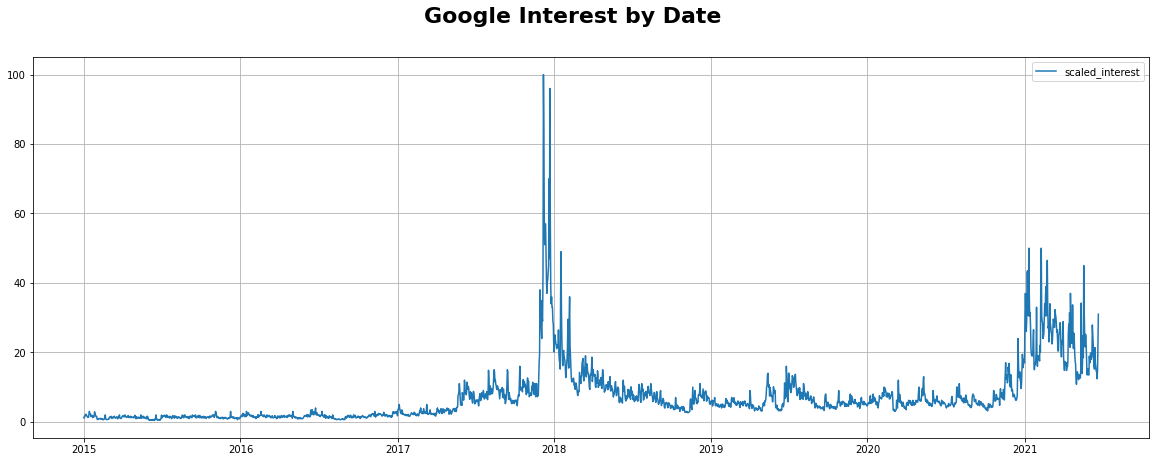

In [11]:
line_plot_by_date(gtrends_df, 'date', ['scaled_interest'], 'Google Interest by Date')

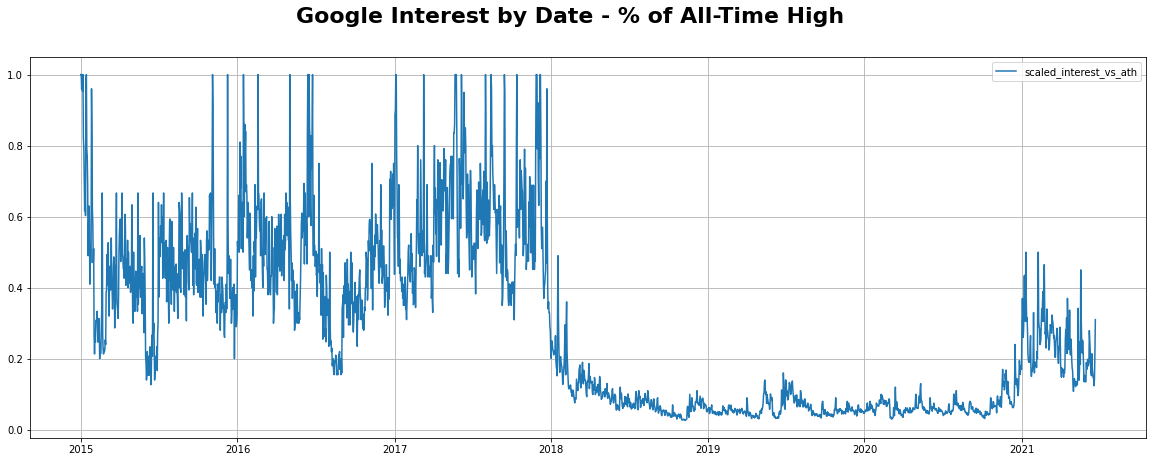

In [12]:
line_plot_by_date(gtrends_df, 'date', ['scaled_interest_vs_ath'], 'Google Interest by Date - % of All-Time High')

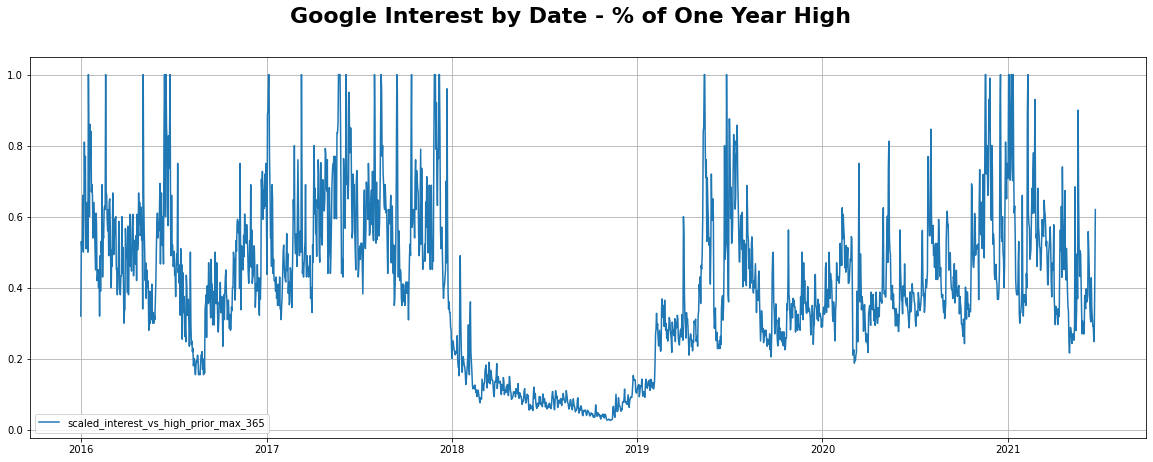

In [13]:
line_plot_by_date(gtrends_df, 'date', ['scaled_interest_vs_high_prior_max_365'], 'Google Interest by Date - % of One Year High')

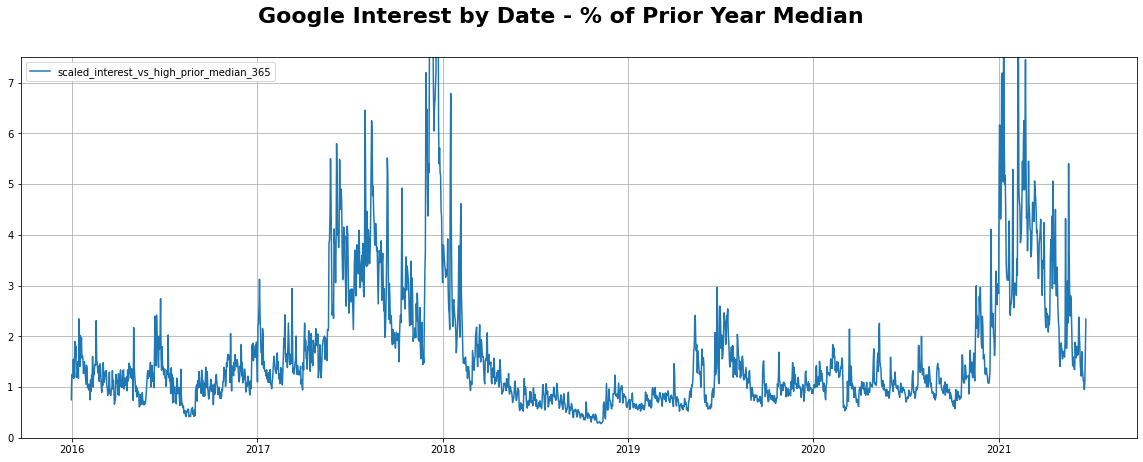

In [14]:
line_plot_by_date(gtrends_df, 'date', ['scaled_interest_vs_high_prior_median_365'], 'Google Interest by Date - % of Prior Year Median', ylim=(0,7.5))

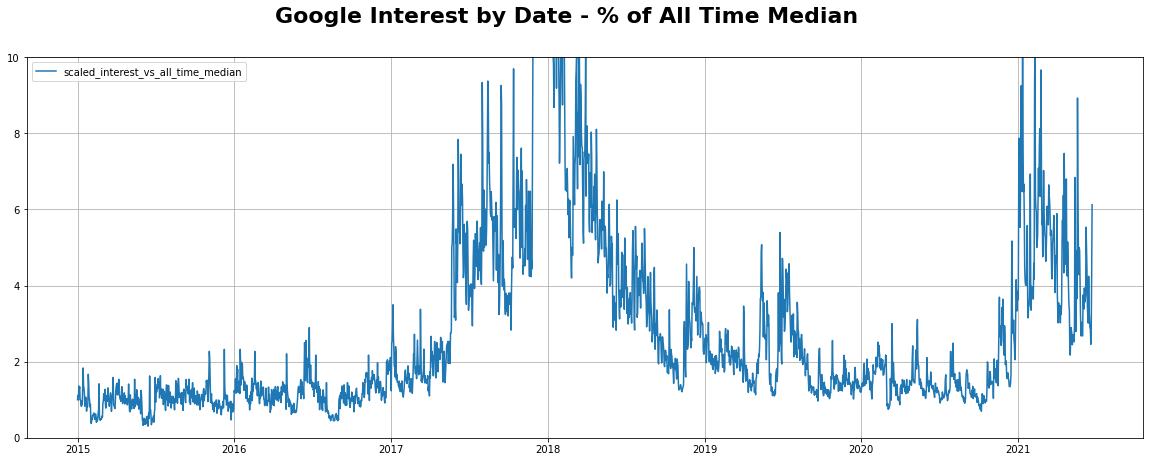

In [15]:
line_plot_by_date(gtrends_df, 'date', ['scaled_interest_vs_all_time_median'], 'Google Interest by Date - % of All Time Median', ylim=(0,10))

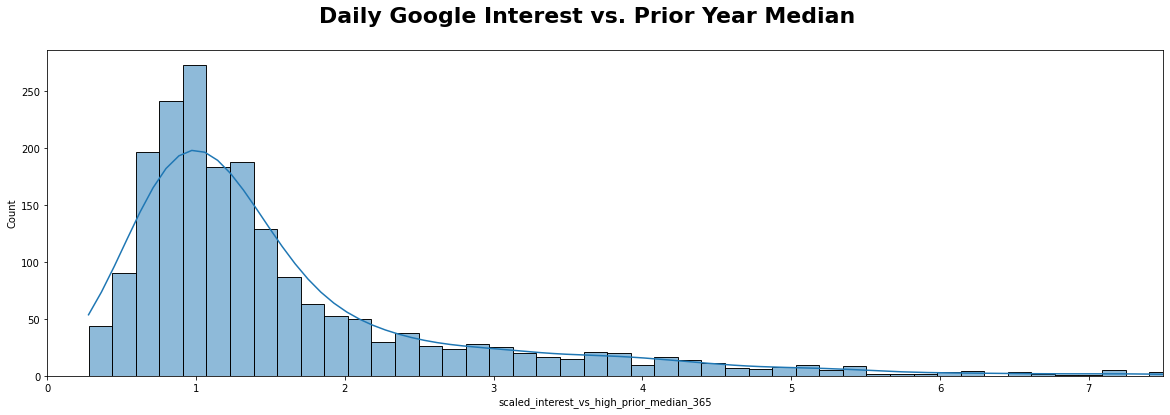

In [16]:
plot_histogram(gtrends_df, 
               x='scaled_interest_vs_high_prior_median_365', 
               title='Daily Google Interest vs. Prior Year Median',
               xlim=(0,7.5)
              )

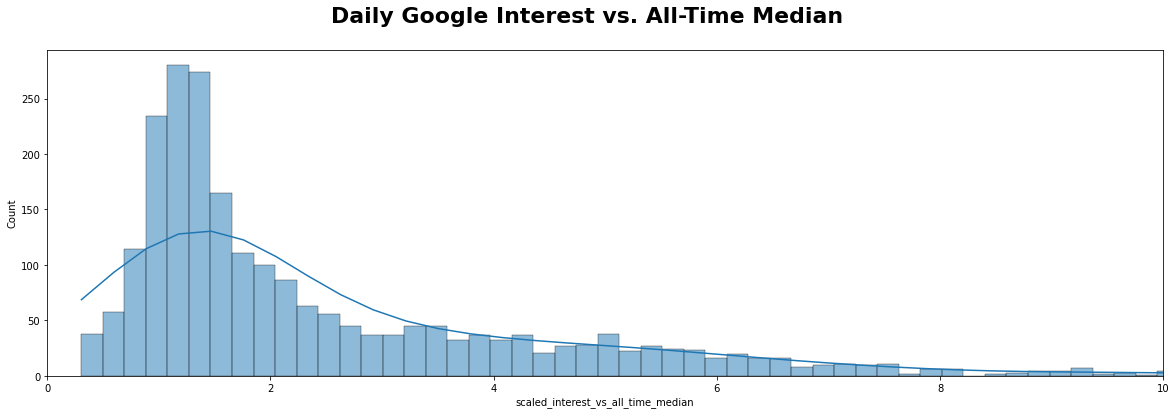

In [17]:
plot_histogram(gtrends_df, 
               x='scaled_interest_vs_all_time_median', 
               title='Daily Google Interest vs. All-Time Median',
               xlim=(0,10),
               bins=300
              )

### Activity by Date - Reddit

Unlike for Google Trends, it doesn't appear that the all-time high calculation requires adjustment for Reddit comments. This is because the Daily Discussion threads only began in January of 2018, after the madness of 2017 had died down. The beginning of the data (2018) is still skewed, because the all-time high calculations are working off of a very small subset of data. However, the shape of the graph is not too dissimilar from the Google Trends data, with the beginning of 2018 being high relative to the remainder of the data. I'll leave it for now and revisit if needed.

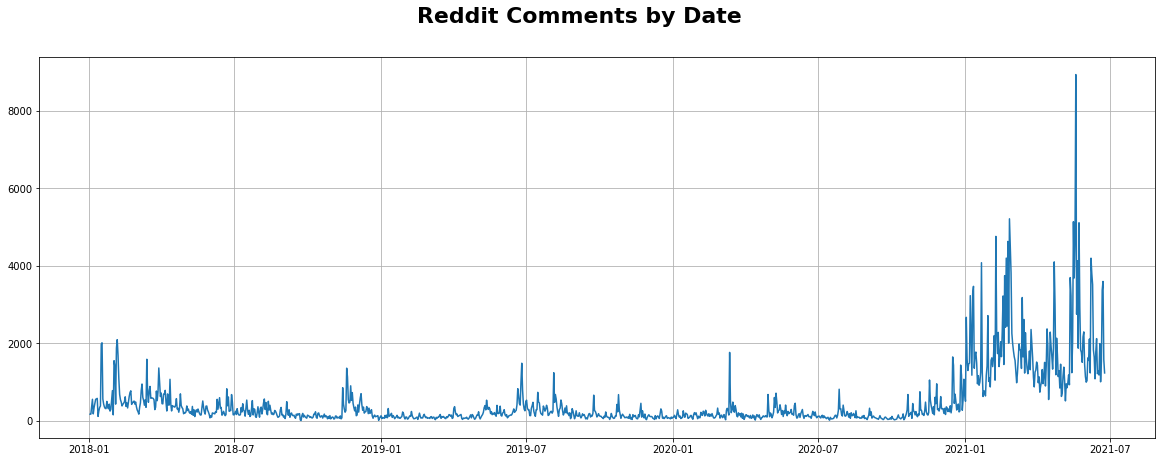

In [18]:
fig = plt.figure(figsize=(20,7))
plt.suptitle('Reddit Comments by Date', fontweight='bold', fontsize=22)
plt.grid(True)
plt.plot(posts_df['date'], posts_df['num_comments']);

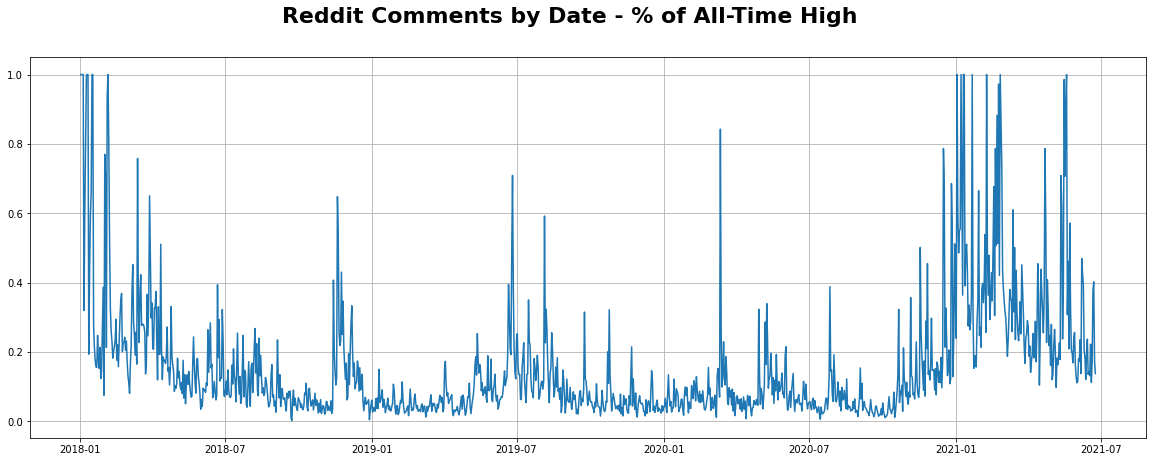

In [19]:
fig = plt.figure(figsize=(20,7))
plt.suptitle('Reddit Comments by Date - % of All-Time High', fontweight='bold', fontsize=22)
plt.grid(True)
plt.plot(posts_df['date'], posts_df['num_comments_vs_ath']);

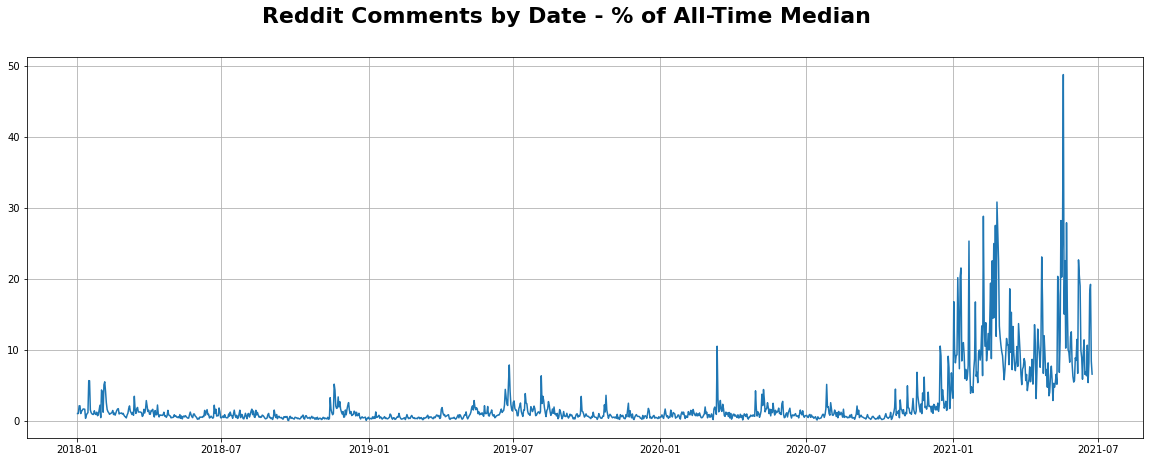

In [20]:
fig = plt.figure(figsize=(20,7))
plt.suptitle('Reddit Comments by Date - % of All-Time Median', fontweight='bold', fontsize=22)
plt.grid(True)
plt.plot(posts_df['date'], posts_df['num_comments_vs_all_time_median']);

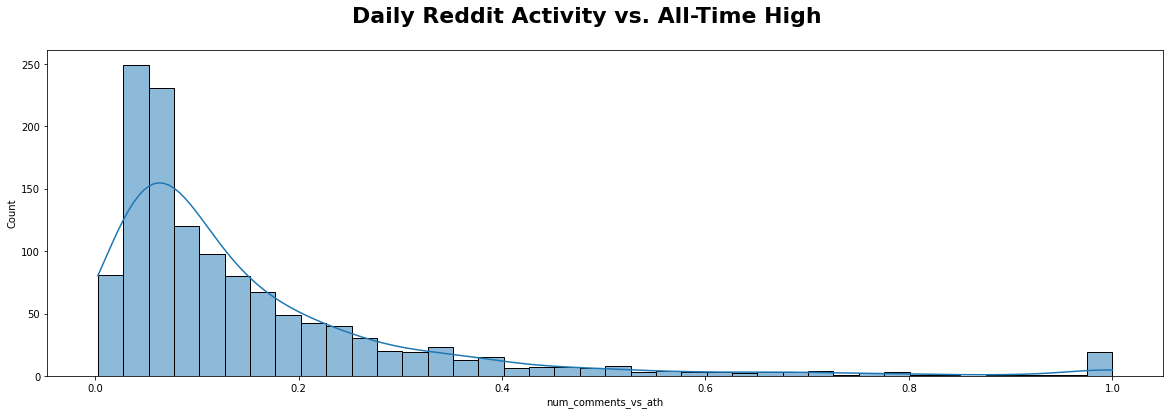

In [21]:
plot_histogram(posts_df, 
               x='num_comments_vs_ath', 
               title='Daily Reddit Activity vs. All-Time High'
              )

### Search for Missing Dates

As you'll see below, missing dates is not a significant issue. From the 3.5 year history of reddit discussion threads, only 3 days are missing. I'll impute some date for these missing records. As for Google Trends, there are predictably no days missing from the data.

In [22]:
# Show missing dates in reddit posts
posts_missing_dates, posts_missing_df = missing_dates_by_year(posts_df, 'date', 'title')
posts_missing_df

,year,missing_dates
0,2018,2
1,2021,1


In [23]:
posts_missing_dates

[datetime.date(2018, 1, 8),
 datetime.date(2018, 1, 29),
 datetime.date(2021, 2, 26)]

In [24]:
# Show missing dates in gtrends
gtrends_missing_dates, gtrends_missing_df = missing_dates_by_year(gtrends_df, 'date', 'scaled_interest')
gtrends_missing_df

,year,missing_dates


### Filter Activity Data to Modeling Columns and Combine

In [25]:
gtrends_modeling_data = gtrends_df[['date', 'scaled_interest_vs_high_prior_median_365', 'scaled_interest_vs_all_time_median']].dropna()[1:]
gtrends_modeling_data.columns = ['date', 'interest_vs_py_median', 'interest_vs_all_time_median']

gtrends_modeling_data.head()

,date,interest_vs_py_median,interest_vs_all_time_median
365,2016-01-01,1.242187,1.242187
366,2016-01-02,1.195312,1.195312
367,2016-01-03,1.195312,1.195312
368,2016-01-04,1.546875,1.546875
369,2016-01-05,1.171875,1.171875


In [26]:
posts_modeling_data = posts_df[['date', 'num_comments_vs_ath']]
activity_data = gtrends_modeling_data.merge(posts_modeling_data, how='left', on='date')

activity_data

,date,interest_vs_py_median,interest_vs_all_time_median,num_comments_vs_ath
0,2016-01-01,1.242187,1.242187,NaN
1,2016-01-02,1.195312,1.195312,NaN
2,2016-01-03,1.195312,1.195312,NaN
3,2016-01-04,1.546875,1.546875,NaN
4,2016-01-05,1.171875,1.171875,NaN
...,...,...,...,...
1995,2021-06-18,1.116475,2.890873,0.222819
1996,2021-06-19,0.950192,2.455446,0.112417
1997,2021-06-20,1.116475,2.879447,0.171089
1998,2021-06-21,1.657754,4.288538,0.377001


### Clean Comments Data - Remove Stickied Comments and Bots

After manual inspection of the comments with "bot" anywhere in the author name, it appears that bots are not a significant problem in the  r/Bitcoin Daily Discussion threads.

In [32]:
# Filter out stickied comments
comments_df = comments_df[comments_df['stickied'] == False]

# Check for bot accounts
potential_bots = [x for x in list(comments_df['author'].str.lower().unique()) if 'bot' in x]
bot_check = comments_df[comments_df['author'].isin(potential_bots)]

bot_check.groupby('author')['timestamp'].count().sort_values(ascending=False)

author
nishbot                 50
recyclops-robotheart    11
bitbotbitbot             7
i-make-robots            2
robotsdev                2
botcoin101               1
fieldbottle              1
pi-robot                 1
robotbun                 1
tetherbot                1
water_bottle_goggles     1
Name: timestamp, dtype: int64

### Pickle Google and Reddit Data for Modeling

In [40]:
# Pickle the data for use in modeling
with open('sentiment_pickles/pickle_activity_data.pickle', 'wb') as to_write:
    pickle.dump(activity_data, to_write)